In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

from PIL import Image
import os
import PIL
import glob

In [13]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
import matplotlib.pyplot as plt

In [3]:
image_dir = "../train_set/train_set"
labels_file = "../train_labels.csv"
resized_train_dir = "../resized_train_set"
img_size = (100, 100)
n_batches = 300
n_labels = 80

In [4]:
labels = pd.read_csv(labels_file)
labels

,img_name,label
0,train_1.jpg,21
1,train_2.jpg,29
2,train_3.jpg,17
3,train_4.jpg,21
4,train_5.jpg,50
...,...,...
30607,train_30608.jpg,53
30608,train_30609.jpg,18
30609,train_30610.jpg,6
30610,train_30611.jpg,21


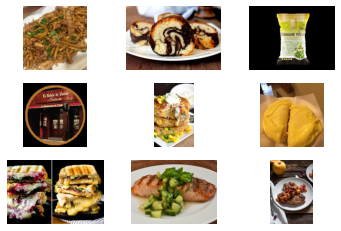

In [5]:
def plot_random_images(img_names, n_x=2, n_y=2, seed=0):
    f, axs = plt.subplots(n_x, n_y)
    sample = img_names.sample(n_x * n_y, random_state=seed)
    c = 0
    for x in range(n_x):
        for y in range(n_y):
            img = plt.imread(image_dir + "/" + sample.iloc[c])
            axs[x, y].imshow(img)
            axs[x, y].axis('off')
            c += 1

plot_random_images(labels["img_name"], 3, 3)

# Image size
Most machine learning requires that the input is always of the same size. Because our images are not always of the same size. We have to resize them

In [6]:
def resize_images(img_names, img_dir, new_img_dir):
    for img in img_names:
        Image.open(image_dir + "/" + img).resize(img_size).save(new_img_dir + "/" + img)

# resize_images(labels["img_name"], image_dir, resized_train_dir)

# Labels
for classification, we need to one hot encode the data

In [7]:
l = list(range(1,n_labels + 1))

def encode(labels):
    z = np.zeros((len(labels), n_labels))
    for i, label in enumerate(labels):
        z[i, label-1] = 1
    return z

# Split
To test our models locally, we must split our data into a train and test set


In [8]:
X_train, X_test, y_train, y_test = train_test_split(labels["img_name"].to_numpy(), labels["label"].to_numpy(), test_size=0.33, random_state=42)

Because the data set is very large, it is a good idea to split the sets into batches.

In [9]:
X_train_batches = np.array_split(X_train, n_batches)
X_test_batches = np.array_split(X_test, n_batches)
y_train_batches = np.array_split(y_train, n_batches)
y_test_batches = np.array_split(y_test, n_batches)

# Image Loading

In [10]:
def load_images(img_names, img_dir):
    res = np.zeros((len(img_names), img_size[0], img_size[1], 3))
    for i, img in enumerate(img_names):
        res[i] = plt.imread(img_dir + "/" + img)
    return res

load_images(X_train_batches[0], resized_train_dir).shape

(69, 100, 100, 3)

# Example: simple CNN

In [14]:
model = models.Sequential()

model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(img_size[0], img_size[1], 3)))

# convolutional layer
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))

#output layer
model.add(layers.Dense(80))
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 50)      1400      
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 75)      33825     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 75)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 50, 75)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 125)       84500     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 125)      0         
 2D)                                                  

In [15]:
history = []
for i in range(0,10):
    for batch_n in range(20):
        X = load_images(X_train_batches[batch_n], resized_train_dir)
        Y = encode(y_train_batches[batch_n])
        test_images = load_images(X_test_batches[0], resized_train_dir)
        test_labels = encode(y_test_batches[0])
        history.append(model.fit(X, Y, validation_data=(test_images, test_labels)))

3/3 [==============================] - 2s 600ms/step - loss: 4.3696 - accuracy: 0.0000e+00 - val_loss: 4.3793 - val_accuracy: 0.0294


3/3 [==============================] - 2s 610ms/step - loss: 4.3231 - accuracy: 0.0290 - val_loss: 4.3634 - val_accuracy: 0.0588


3/3 [==============================] - 2s 614ms/step - loss: 4.2590 - accuracy: 0.0725 - val_loss: 4.4443 - val_accuracy: 0.0294


3/3 [==============================] - 2s 690ms/step - loss: 3.8563 - accuracy: 0.0870 - val_loss: 5.2904 - val_accuracy: 0.0294


In [18]:
def history_list_to_single(history_list):
    res = defaultdict(list)
    for h in history_list:
        for k in h.history.keys():
            res[k] = res[k] + h.history[k]
    return res

new_history = history_list_to_single(history)

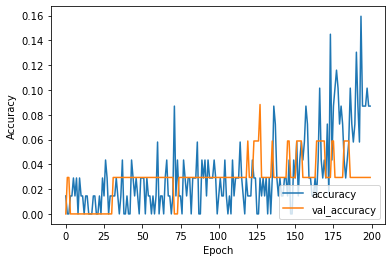

In [19]:
plt.plot(new_history['accuracy'], label='accuracy')
plt.plot(new_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

# More models: